In [25]:
import random

from deap import base
from deap import creator
from deap import tools

In [26]:
# Problem parameter
n = 20

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("IndividualQueen", list, fitness=creator.FitnessMin)

In [27]:
#Since there is only one queen per line, 
#individual are represented by a permutation
toolbox_q = base.Toolbox()
toolbox_q.register("permutation", random.sample, range(n), n)

#Structure initializers
#An individual is a list that represents the position of each queen.
#Only the line is stored, the column is the index of the number in the list.
toolbox_q.register("individual", tools.initIterate, creator.IndividualQueen, toolbox_q.permutation)
toolbox_q.register("population", tools.initRepeat, list, toolbox_q.individual)

In [28]:
def evalNQueens(individual):
    size = len(individual)
    #Count the number of conflicts with other queens.
    #The conflicts can only be diagonal, count on each diagonal line
    left_diagonal = [0] * (2*size-1)
    right_diagonal = [0] * (2*size-1)
    
    #Sum the number of queens on each diagonal:
    for i in range(size):
        left_diagonal[i+individual[i]] += 1
        right_diagonal[size-1-i+individual[i]] += 1
    
    #Count the number of conflicts on each diagonal
    sum_ = 0
    for i in range(2*size-1):
        if left_diagonal[i] > 1:
            sum_ += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            sum_ += right_diagonal[i] - 1
    return sum_,

In [29]:
def cxPartialyMatched(ind1, ind2):
    """Executes a partially matched crossover (PMX) on the input individuals.
    The two individuals are modified in place. This crossover expects
    :term:`sequence` individuals of indices, the result for any other type of
    individuals is unpredictable.
    
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.
    Moreover, this crossover generates two children by matching
    pairs of values in a certain range of the two parents and swapping the values
    of those indexes. For more details see [Goldberg1985]_.
    This function uses the :func:`~random.randint` function from the python base
    :mod:`random` module.
    
    .. [Goldberg1985] Goldberg and Lingel, "Alleles, loci, and the traveling
       salesman problem", 1985.
    """
    size = min(len(ind1), len(ind2))
    p1, p2 = [0]*size, [0]*size

    # Initialize the position of each indices in the individuals
    for i in range(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i
    # Choose crossover points
    cxpoint1 = random.randint(0, size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    
    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap the matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]
    
    return ind1, ind2

In [37]:
def cxTwoPoint(ind1, ind2):
    """Executes a two-point crossover on the input :term:`sequence`
    individuals. The two individuals are modified in place and both keep
    their original length. 
    
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.
    This function uses the :func:`~random.randint` function from the Python 
    base :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
   
    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]
        
    return ind1, ind2

In [45]:
def mutShuffleIndexes(individual, indpb):
    """Shuffle the attributes of the input individual and return the mutant.
    The *individual* is expected to be a :term:`sequence`. The *indpb* argument is the
    probability of each attribute to be moved. Usually this mutation is applied on 
    vector of indices.
    
    :param individual: Individual to be mutated.
    :param indpb: Independent probability for each attribute to be exchanged to
                  another position.
    :returns: A tuple of one individual.
    
    This function uses the :func:`~random.random` and :func:`~random.randint`
    functions from the python base :mod:`random` module.
    """
    # size = len(individual)
    # for i in range(size):
    #     if random.random() < indpb:
    #         swap_indx = random.randint(0, size - 2)
    #         if swap_indx >= i:
    #             swap_indx += 1
    #         individual[i], individual[swap_indx] = \
    #             individual[swap_indx], individual[i]
    
    # return individual,

    return random.shuffle(individual)

In [39]:
toolbox_q.register("evaluate", evalNQueens)
toolbox_q.register("mate", cxPartialyMatched)
toolbox_q.register("mutate", mutShuffleIndexes, indpb=2.0/n)
toolbox_q.register("select", tools.selTournament, tournsize=3)

In [46]:
pop = toolbox_q.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in range(100):
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox_q.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 5.0
  Max 16.0
  Avg 9.626666666666667
  Std 2.060895166884742
-- Generation 1 --
  Min 5.0
  Max 15.0
  Avg 8.953333333333333
  Std 1.9709106750152063
-- Generation 2 --
  Min 5.0
  Max 14.0
  Avg 8.616666666666667
  Std 2.0727732362438696
-- Generation 3 --
  Min 5.0
  Max 17.0
  Avg 8.573333333333334
  Std 2.0341965380846405
-- Generation 4 --
  Min 4.0
  Max 16.0
  Avg 8.696666666666667
  Std 2.340510390681672
-- Generation 5 --
  Min 5.0
  Max 15.0
  Avg 8.75
  Std 2.144955321990024
-- Generation 6 --
  Min 5.0
  Max 17.0
  Avg 8.76
  Std 2.341452540625156
-- Generation 7 --
  Min 4.0
  Max 16.0
  Avg 8.536666666666667
  Std 2.3597998973547605
-- Generation 8 --
  Min 4.0
  Max 15.0
  Avg 8.256666666666666
  Std 2.272470510748654
-- Generation 9 --
  Min 4.0
  Max 16.0
  Avg 8.076666666666666
  Std 2.4894689304258377
-- Generation 10 --
  Min 4.0
  Max 15.0
  Avg 7.873333333333333
  Std 2.571113031786471
-- Generation 11 --
  Min 4.0
  Max 15.0
  Avg 8.08


-- Generation 0 --
  Min 4.0
  Max 18.0
  Avg 9.553333333333333
  Std 1.8869257772601704
-- Generation 1 --
  Min 4.0
  Max 15.0
  Avg 9.07
  Std 2.061981247894038
-- Generation 2 --
  Min 4.0
  Max 15.0
  Avg 8.58
  Std 2.2398511855329453
-- Generation 3 --
  Min 4.0
  Max 15.0
  Avg 8.383333333333333
  Std 2.321577528798518
-- Generation 4 --
  Min 4.0
  Max 14.0
  Avg 8.426666666666666
  Std 2.324784338862904
-- Generation 5 --
  Min 4.0
  Max 14.0
  Avg 8.246666666666666
  Std 2.3872904212842565
-- Generation 6 --
  Min 2.0
  Max 15.0
  Avg 8.103333333333333
  Std 2.6101064260975195
-- Generation 7 --
  Min 2.0
  Max 16.0
  Avg 8.126666666666667
  Std 2.6084392949722917
-- Generation 8 --
  Min 2.0
  Max 15.0
  Avg 7.866666666666666
  Std 2.6898988002442703
-- Generation 9 --
  Min 2.0
  Max 16.0
  Avg 7.413333333333333
  Std 2.4810929491299247
-- Generation 10 --
  Min 2.0
  Max 16.0
  Avg 7.403333333333333
  Std 2.710594440749524
-- Generation 11 --
  Min 2.0
  Max 14.0
  Avg 7.2

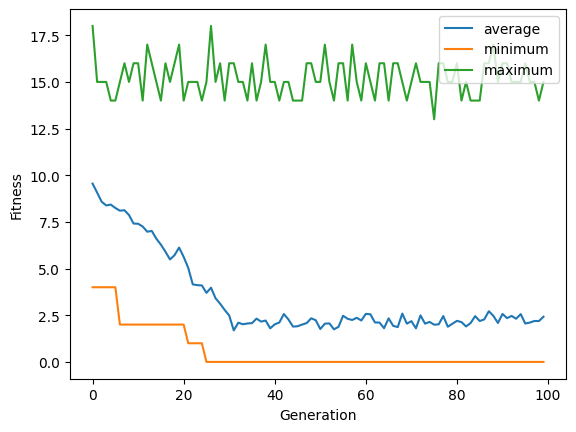

In [50]:
gen = range(100)
avg_list = []
max_list = []
min_list = []

pop = toolbox_q.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox_q.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    
import matplotlib.pyplot as plt
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()